In [ ]:
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Reshape,LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten
from keras.layers import GlobalMaxPooling2D, Conv3D, MaxPooling3D, ConvLSTM2D, Add
from keras.models import Model
from keras.initializers import Constant
import tensorflow as tf

import pickle

In [ ]:
from keras.layers import Input, LSTM, Bidirectional, Concatenate, Dense, Dropout, Flatten, Attention, Conv1D, MaxPooling1D
from keras.models import Model

def create_complex_multimodal_model(input_shape_text, input_shape_audio, num_classes):
    # Text input
    text_input = Input(shape=input_shape_text, name='text_input')
    # Audio input
    audio_input = Input(shape=input_shape_audio, name='audio_input')

    # Text processing layers
    text_lstm1 = Bidirectional(LSTM(128, return_sequences=True))(text_input)
    text_lstm2 = Bidirectional(LSTM(64, return_sequences=True))(text_lstm1)
    text_attention = Attention()([text_lstm2, text_lstm2])
    text_dropout = Dropout(0.5)(text_attention)
    text_flatten = Flatten()(text_dropout)

    # Audio processing layers
    audio_conv1 = Conv1D(64, 3, activation='relu')(audio_input)
    audio_pool1 = MaxPooling1D(pool_size=2)(audio_conv1)
    audio_conv2 = Conv1D(128, 3, activation='relu')(audio_pool1)
    audio_pool2 = MaxPooling1D(pool_size=2)(audio_conv2)
    audio_lstm1 = Bidirectional(LSTM(64, return_sequences=True))(audio_pool2)
    audio_lstm2 = Bidirectional(LSTM(32, return_sequences=True))(audio_lstm1)
    audio_attention = Attention()([audio_lstm2, audio_lstm2])
    audio_dropout = Dropout(0.5)(audio_attention)
    audio_flatten = Flatten()(audio_dropout)

    # Concatenate text and audio features
    merged_features = Concatenate()([text_flatten, audio_flatten])

    # Fully connected layers
    fc1 = Dense(512, activation='relu')(merged_features)
    fc_dropout = Dropout(0.5)(fc1)

    # Output layer
    output = Dense(num_classes, activation='softmax')(fc_dropout)

    # Create model
    model = Model(inputs=[text_input, audio_input], outputs=output)

    return model

In [ ]:
modal=create_complex_multimodal_model([385,1],[155,1],7)

In [ ]:
modal.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 audio_input (InputLayer)    [(None, 155, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 153, 64)              256       ['audio_input[0][0]']         
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 76, 64)               0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 74, 128)              24704     ['max_pooling1d[0][0]']   

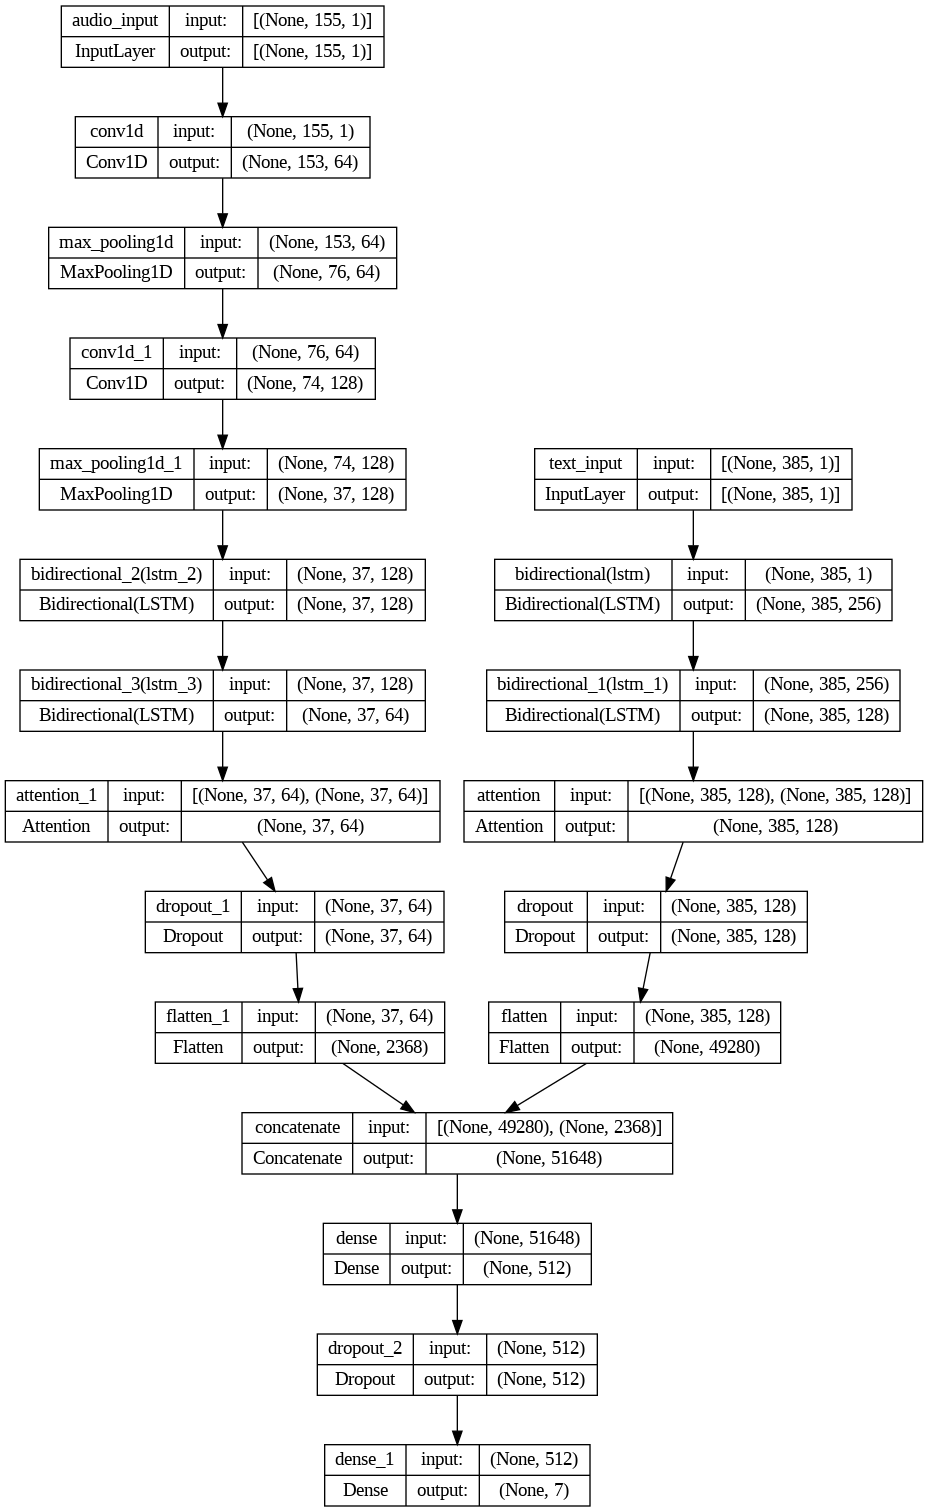

In [ ]:
tf.keras.utils.plot_model(modal, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, LSTM, Bidirectional, Concatenate, Dense, Attention, Dropout, BatchNormalization , Flatten
import numpy as np
import pandas as pd

def create_and_train_multimodal_model():
    # Define inputs
    text_input = Input(shape=(384,1), name='text_input')
    audio_input = Input(shape=(155,1), name='audio_input')  # Changed shape to add third dimension

    # BiLSTM for text analysis
    text_bilstm = Bidirectional(LSTM(256, return_sequences=True))(text_input)
    # Attention mechanism for text
    text_attention = Attention()([text_bilstm,text_bilstm])
    # Dropout layer to prevent overfitting
    text_dropout = Dropout(0.5)(text_attention)
    # Batch normalization for stabilizing training
    text_batch_norm = BatchNormalization()(text_dropout)

    # BiLSTM for audio analysis
    audio_bilstm = Bidirectional(LSTM(256, return_sequences=True))(audio_input)
    # Attention mechanism for audio
    audio_attention = Attention()([audio_bilstm,audio_bilstm])
    # Dropout layer to prevent overfitting
    audio_dropout = Dropout(0.5)(audio_attention)
    # Batch normalization for stabilizing training
    audio_batch_norm = BatchNormalization()(audio_dropout)


    # Flatten attention outputs
    text_batch_norm = Flatten()(text_batch_norm)
    audio_batch_norm = Flatten()(audio_batch_norm)

    # Concatenate outputs of attention layers
    concatenated = Concatenate()([text_batch_norm, audio_batch_norm])

    # Fully connected layer
    fc_layer = Dense(512, activation='relu')(concatenated)
    # Dropout layer
    fc_dropout = Dropout(0.5)(fc_layer)
    # Batch normalization
    fc_batch_norm = BatchNormalization()(fc_dropout)

    # Output layer
    output = Dense(7, activation='softmax')(fc_batch_norm)

    # Create and compile model
    model = Model(inputs=[text_input, audio_input], outputs=output)


    return model

trained_model = create_and_train_multimodal_model()


In [ ]:
trained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 384, 1)]             0         []                            
                                                                                                  
 audio_input (InputLayer)    [(None, 155, 1)]             0         []                            
                                                                                                  
 bidirectional_4 (Bidirecti  (None, 384, 512)             528384    ['text_input[0][0]']          
 onal)                                                                                            
                                                                                                  
 bidirectional_5 (Bidirecti  (None, 155, 512)             528384    ['audio_input[0][0]']   

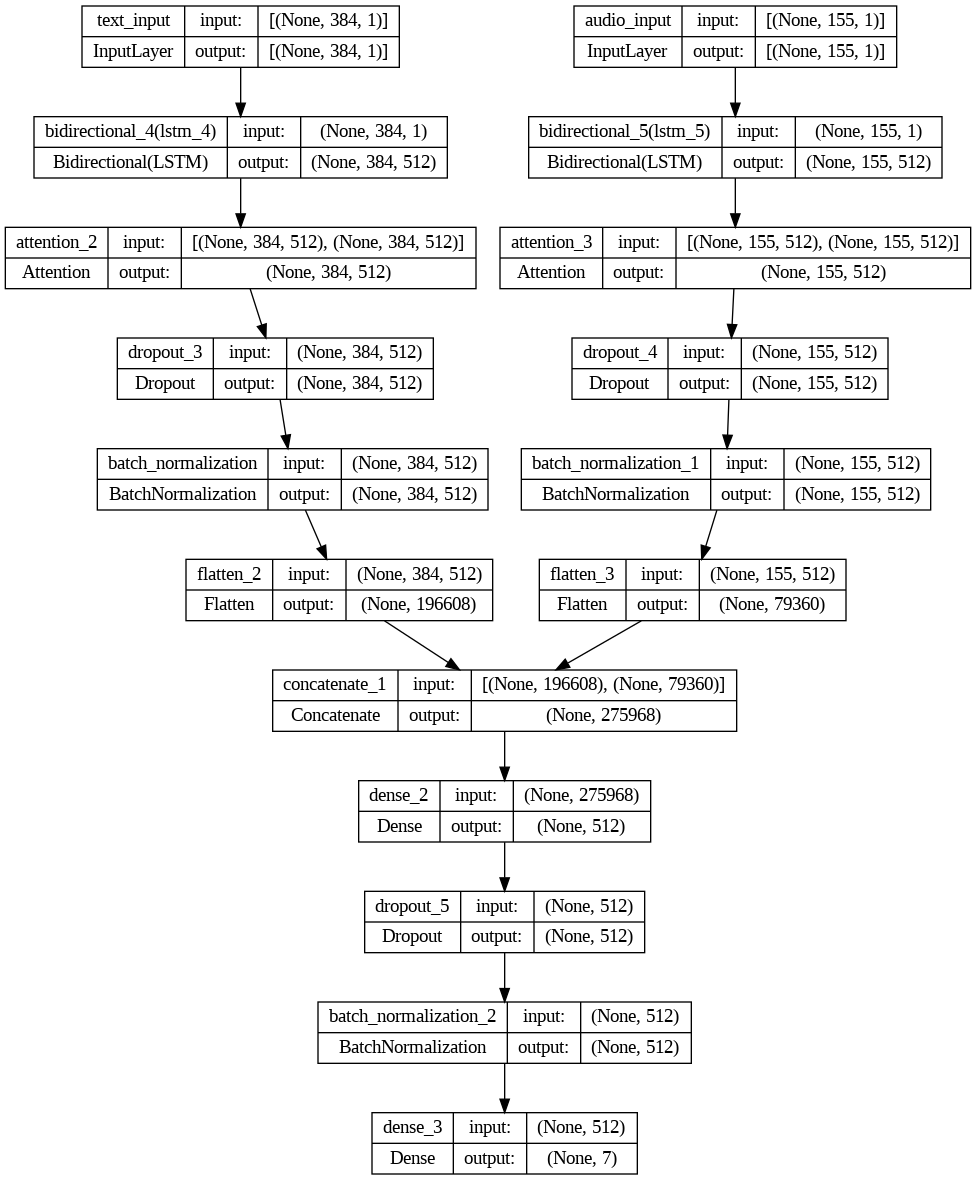

In [ ]:
tf.keras.utils.plot_model(trained_model, to_file='model.png', show_shapes=True, show_layer_names=True)